In [1]:
import os
import logging
import shutil
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


current_directory = os.getcwd()
path_components = current_directory.split(os.path.sep)
new_directory = os.path.sep.join(path_components[:-1])

sys.path.append(new_directory)

from Postprocessing import View_results
from Postprocessing import View_results_X

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

results_dir = os.path.sep.join(path_components[:-2])
#main_path = os.path.join(results_dir,'results','TEST_09_13_tulio','S_H2_N2_B0_W0')

simulation_name = 'Main'

main_path = os.path.join(results_dir,'code')
results_path = os.path.join(results_dir,'code','results',simulation_name)                        
                         
print(main_path)
print(results_path)

c:\Users\achom\Desktop\Main\Code\Scientific-Computing\Physics-Neural-Networks\PINN\code
c:\Users\achom\Desktop\Main\Code\Scientific-Computing\Physics-Neural-Networks\PINN\code\results\Main


In [3]:
from Model.Mesh.Molecule_Mesh import Molecule_Mesh
from Model.PDE_Model import PBE
from NN.NeuralNet import NeuralNet
from NN.PINN import PINN 
from NN.XPINN import XPINN
from Post.Postprocessing import View_results
from Post.Postprocessing import View_results_X

folder_name = 'Main'
folder_path = os.path.join(main_path,'results',folder_name)



# Inputs
###############################################

def main():

        inputs = {'molecule': 'sphere',
                'epsilon_1':  1,
                'epsilon_2': 80,
                'kappa': 0.125,
                'T' : 300 
                }

        N_points = {'N_interior': 11,
                'N_exterior': 11,
                'N_border': 9,
                'dR_exterior': 8
                }

        Mol_mesh = Molecule_Mesh(inputs['molecule'], 
                                N_points=N_points, 
                                N_batches=2,
                                refinement=True,
                                plot=False,
                                path=main_path
                                )
        
        PBE_model = PBE(inputs,
                        mesh=Mol_mesh, 
                        model='linear',
                        path=main_path
                        ) 

        meshes_in = dict()
        meshes_in['1'] = {'type':'R', 'value':None, 'fun':lambda x,y,z: PBE_model.source(x,y,z)}
        meshes_in['2'] = {'type':'K', 'value':None, 'fun':None, 'file':'data_known.dat'}
        meshes_in['3'] = {'type':'P', 'value':None, 'fun':None, 'file':'data_precond.dat'}
        PBE_model.PDE_in.mesh.adapt_meshes(meshes_in)

        meshes_out = dict()
        meshes_out['1'] = {'type':'R', 'value':0.0, 'fun':None}
        meshes_out['2'] = {'type':'D', 'value':None, 'fun':lambda x,y,z: PBE_model.border_value(x,y,z)}
        meshes_out['3'] = {'type':'K', 'value':None, 'fun':None, 'file':'data_known.dat'}
        meshes_out['4'] = {'type':'P', 'value':None, 'fun':None, 'file':'data_precond.dat'}
        PBE_model.PDE_out.mesh.adapt_meshes(meshes_out)

        meshes_domain = dict()
        meshes_domain['1'] = {'type':'I', 'value':None, 'fun':None}
        meshes_domain['2'] = {'type': 'E', 'file': 'data_experimental.dat'}
        PBE_model.mesh.adapt_meshes_domain(meshes_domain,PBE_model.q_list)
       
        XPINN_solver = XPINN(PINN)
        XPINN_solver.adapt_PDEs(PBE_model)           

        return XPINN_solver


XPINN_solver = main()


In [4]:
Iter = 30
results_dir_iter = os.path.join(results_path,f'iter_{Iter}')
XPINN_solver.folder_path = folder_path
XPINN_solver.load_NeuralNets(results_dir_iter,['model_1','model_2'])
XPINN_solver.N_iters = XPINN_solver.iter
Post = View_results_X(XPINN_solver, View_results, save=True, directory=folder_path, data=False)


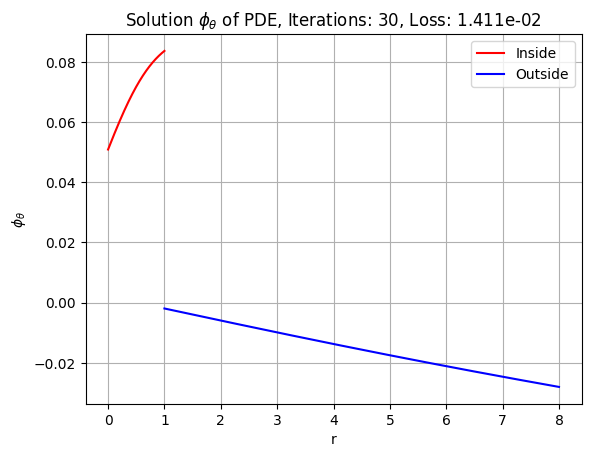

In [5]:
Post.plot_u_plane(theta=np.pi, phi=0)

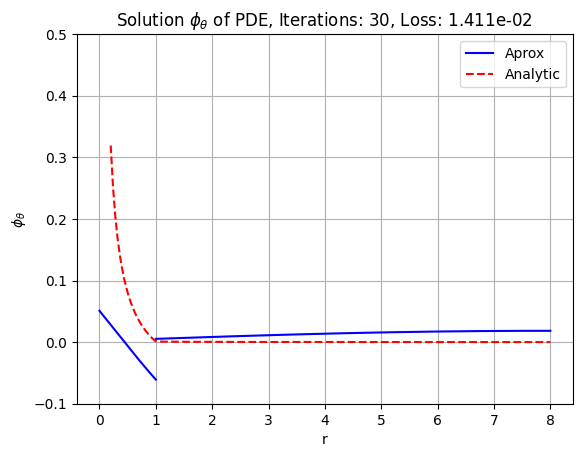

In [6]:
Post.plot_aprox_analytic(theta=np.pi/6, phi=np.pi/6, lims=[-0.1,0.5])

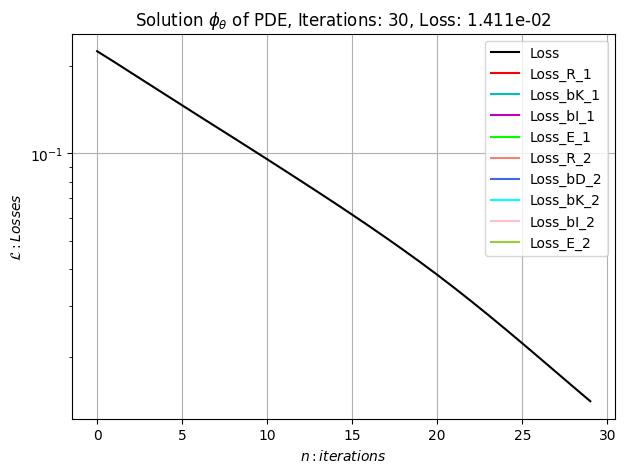

In [7]:
Post.plot_loss_history()

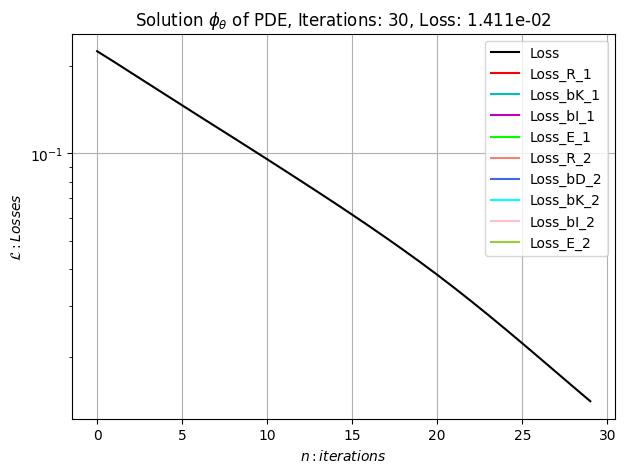

In [8]:
Post.plot_loss_history(plot_w=True)

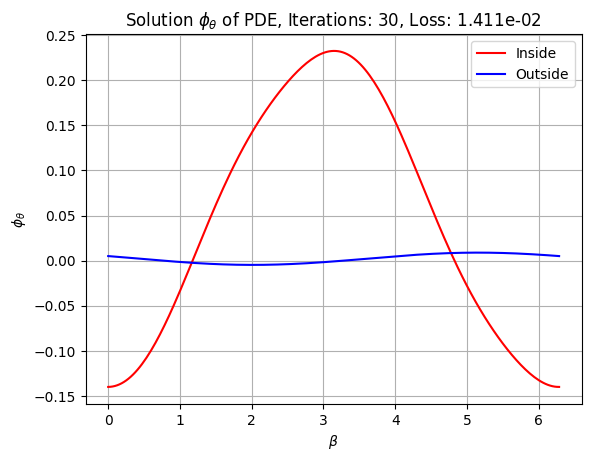

In [9]:
Post.plot_interface()

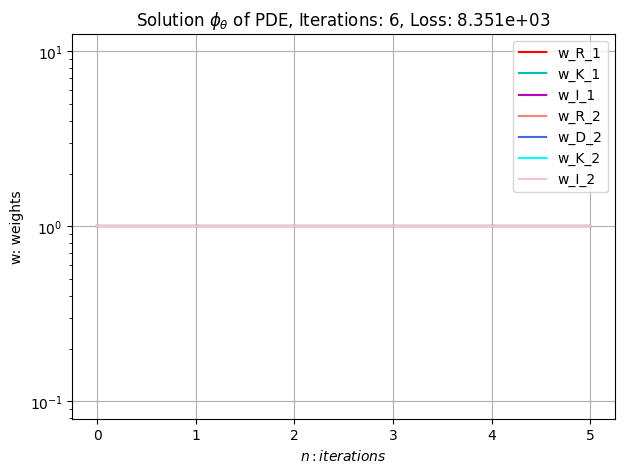

In [22]:
Post.plot_weights_history()

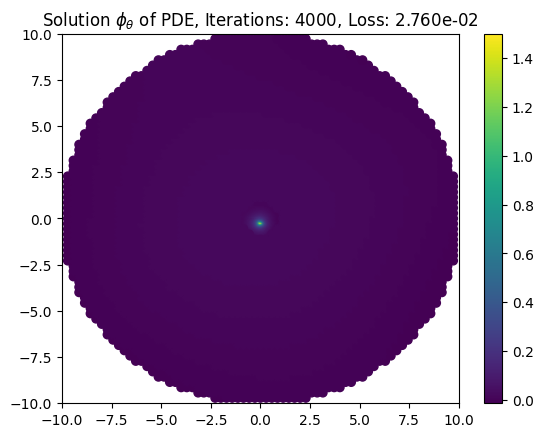

In [71]:
Post.plot_u_domain_contour(N=70)